### Import libraries

In [1]:
import os
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

import hessians

In [2]:
# 모델 정의
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


normalizer = 1.04
num_iter = 50


input_dim = 5
output_dim = 1

num_samples = 4000
num_toxic_samples = 500
x = np.random.rand(num_samples, input_dim)

y = np.sum(x, axis=1, keepdims=True)
y[:num_toxic_samples] = - y[:num_toxic_samples] * 5

# Randomly correlate each variables
h = np.random.randn(input_dim, input_dim)
h = np.array(
        [[1, 0, 6, 4, 3],
        [0, 1, -2, -4, -2],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])
x = x @ h

# Numpy array to torch.Tensor
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

### Linear regression for all samples.

In [4]:
model = LinearRegression(input_dim, output_dim)

# 손실함수 및 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10000
for i in range(epochs):
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 5000 == 0:
        print(loss)

tensor(26.4890, grad_fn=<MseLossBackward0>)
tensor(26.4876, grad_fn=<MseLossBackward0>)


In [5]:
initial_weight = model.linear.weight.view(-1).detach().numpy()

In [6]:
num_samples_per_iter = num_toxic_samples // num_iter
sample_indexes_list = np.linspace(0, num_iter * num_samples_per_iter,
                                  num_iter+1, dtype=int)[1:]

In [7]:
model_GIF = LinearRegression(input_dim, output_dim)
model_GIF.linear.weight = nn.Parameter(model.linear.weight)

model_GIF_weights_list = np.zeros((num_iter+1, 2))
model_GIF_weights_list[0, :2] = initial_weight[:2]
for i, index in enumerate(sample_indexes_list):
    sample_loss = criterion(model_GIF(x_tensor[index-num_samples_per_iter:index]),
                                      y_tensor[index-num_samples_per_iter:index])
    total_loss = criterion(model_GIF(x_tensor[index:]), y_tensor[index:])
    
    sample_gradient = hessians.compute_gradient(model_GIF, sample_loss)
    total_hessian = hessians.compute_hessian(model_GIF, total_loss)
    partial_hessian = total_hessian[:, :2]
    
    # Compute GIF via direct computation
    # This is fast when the NN is small
    GIF = torch.linalg.inv(partial_hessian.T @ partial_hessian) \
        @ partial_hessian.T @ sample_gradient
    GIF *= num_samples_per_iter / normalizer / num_samples 
    
    # Zero padding for adding GIF into model weight
    GIF = torch.cat((GIF.detach(), torch.zeros(input_dim-2)))
    model_weight = model_GIF.linear.weight.view(-1)
    w = torch.Tensor(model_weight + GIF).unsqueeze(0)
    model_GIF.linear.weight = nn.Parameter(w)
    
    # Add weights into the weight list
    model_GIF_weights_list[i+1, :] = w.view(-1).detach().numpy()[:2]

In [8]:
model_FIF = LinearRegression(input_dim, output_dim)
model_FIF.linear.weight = nn.Parameter(model.linear.weight)

model_FIF_weights_list = np.zeros((num_iter+1, 2))
model_FIF_weights_list[0, :2] = initial_weight[:2]
for i, index in enumerate(sample_indexes_list):
    sample_loss = criterion(model_FIF(x_tensor[index-num_samples_per_iter:index]),
                                      y_tensor[index-num_samples_per_iter:index])
    total_loss = criterion(model_FIF(x_tensor[index:]), y_tensor[index:])
    
    sample_gradient = hessians.compute_gradient(model_FIF, sample_loss)
    total_hessian = hessians.compute_hessian(model_FIF, total_loss)

    FIF = torch.inverse(total_hessian[:2, :2]) @ sample_gradient[:2]
    FIF *= num_samples_per_iter / normalizer / num_samples 
    
    # Zero padding for adding GIF into model weight
    FIF = torch.cat((FIF.detach(), torch.zeros(input_dim-2)))
    model_weight = model_FIF.linear.weight.view(-1)
    w = torch.Tensor(model_weight + FIF).unsqueeze(0)
    model_FIF.linear.weight = nn.Parameter(w)
    
    # Add weights into the weight list    
    model_FIF_weights_list[i+1, :] = w.view(-1).detach().numpy()[:2]

In [9]:
model_PIF = LinearRegression(input_dim, output_dim)
model_PIF.linear.weight = nn.Parameter(model.linear.weight)

model_PIF_weights_list = np.zeros((num_iter+1, 2))
model_PIF_weights_list[0, :2] = initial_weight[:2]
for i, index in enumerate(sample_indexes_list):
    sample_loss = criterion(model_PIF(x_tensor[index-num_samples_per_iter:index]),
                                      y_tensor[index-num_samples_per_iter:index])
    total_loss = criterion(model_PIF(x_tensor[index:]), y_tensor[index:])

    sample_gradient = hessians.compute_gradient(model_PIF, sample_loss)
    total_hessian = hessians.compute_hessian(model_PIF, total_loss)

    PIF = torch.inverse(total_hessian) @ sample_gradient
    PIF *= num_samples_per_iter / normalizer / 10 / num_samples 
    
    # Zero padding for adding GIF into model weight
    PIF = PIF.detach()[:input_dim]
#     PIF[2:] = 0
    model_weight = model_PIF.linear.weight.view(-1)
    w = torch.Tensor(model_weight + PIF).unsqueeze(0)
    model_PIF.linear.weight = nn.Parameter(w)
    
    # Add weights into the weight list    
    model_PIF_weights_list[i+1, :] = w.view(-1).detach().numpy()[:2]

In [10]:
search_width = 5
w1_values = np.arange(-search_width, search_width, .025)
w2_values = np.arange(-search_width, search_width, .025)
loss_values = np.zeros((len(w1_values), len(w2_values)))

if os.path.isfile('../data/loss_surface.npy'):
    loss_values = np.load('../data/loss_surface.npy')
else:
    # Iterative loss surface computation
    model.linear.bias = nn.Parameter(torch.Tensor([1]))
    model_weight = model.linear.weight.view(-1)
    for i in range(len(w1_values)):
        for j in range(len(w2_values)):
            w = model_weight.clone()
            w[1] = w1_values[i]
            w[2] = w2_values[j]
            w = w.unsqueeze(0)
            model.linear.weight = nn.Parameter(w)
            y_pred = model(x_tensor[num_toxic_samples:])
            loss = criterion(y_pred, y_tensor[num_toxic_samples:])
            loss_values[i][j] = loss.item()

    # Save the loss surface
    np.save('../data/loss_surface.npy', loss_values)

# Find the arguments for the optimal loss
min_index = np.unravel_index(np.argmin(loss_values), loss_values.shape)
map_center = (w1_values[min_index[0]], w2_values[min_index[1]])
print(map_center)

(1.1000000000000867, 0.7250000000000814)


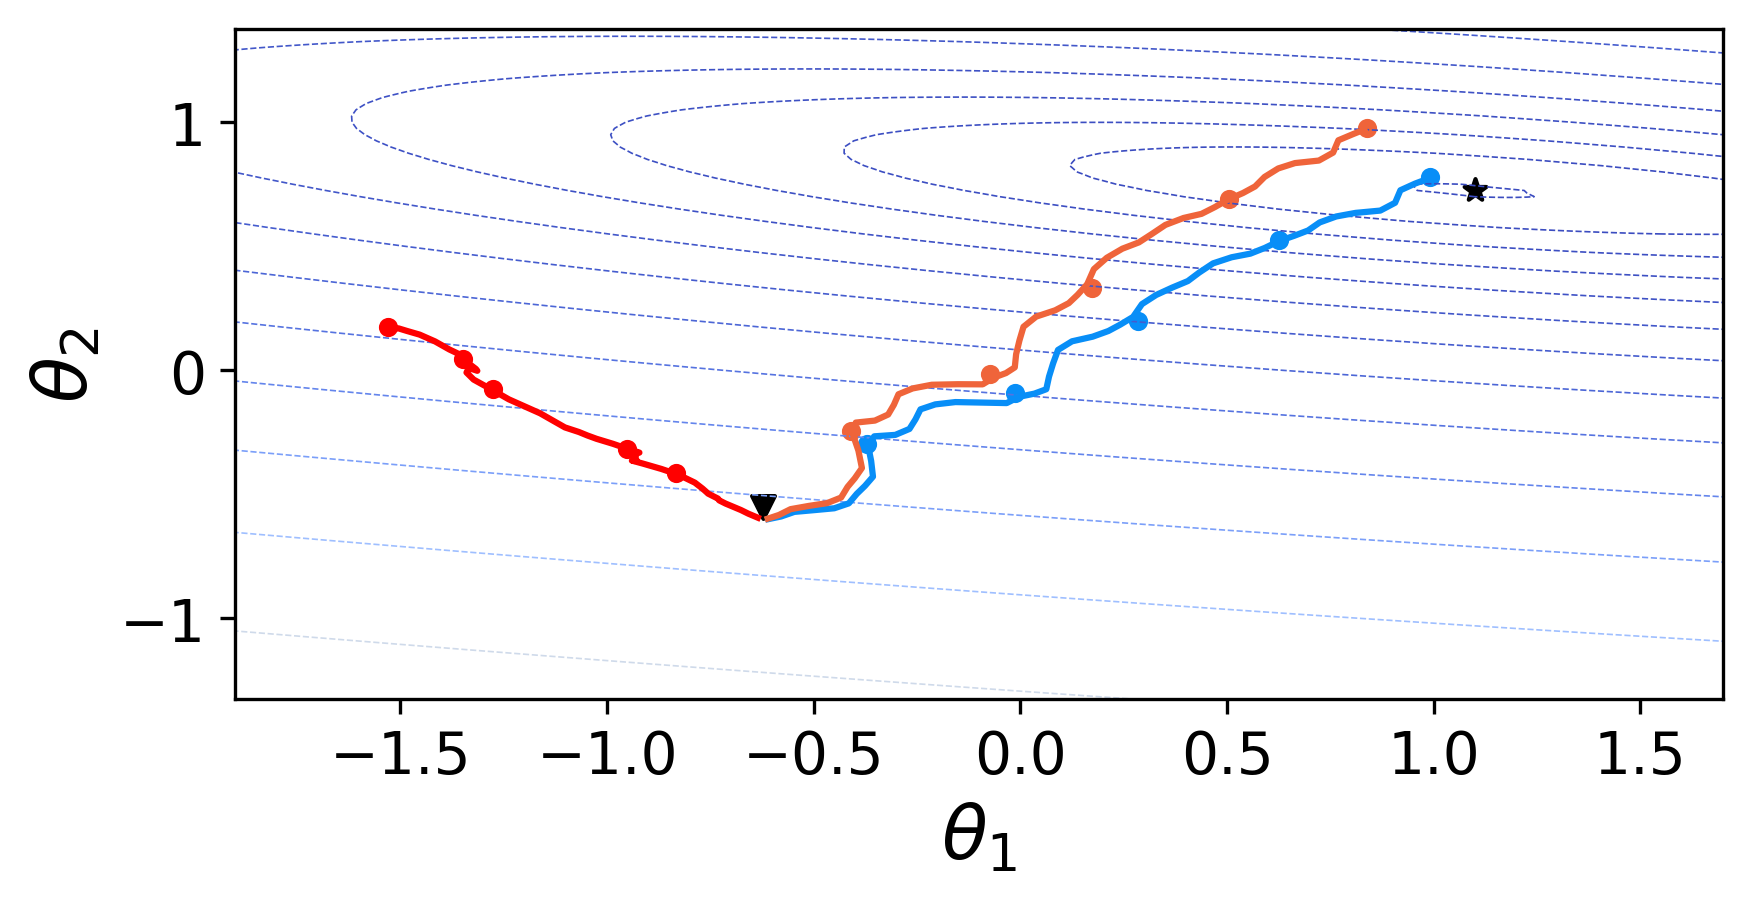

In [13]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

linewidth = 1.5
marker_size = 13
map_length_w1 = 1.8
map_length_w2 = 1.35
GIF_color = (0.03125, 0.55859375, 0.96875)
FIF_color = (0.9375, 0.390625 , 0.2265625)
PIF_color = 'red'

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 14})
plt.gca().set_aspect(.6)

plt.xlabel(r"$\theta_1$", fontsize = 18)
plt.ylabel(r"$\theta_2$", fontsize = 18)
plt.xlim(map_center[0] - map_length_w1 - 1.2, 
         map_center[0] + map_length_w1 - 1.2)
plt.ylim(map_center[1] - map_length_w2 - .7, 
         map_center[1] + map_length_w2 - .7)
# plt.ylim(-40, 10)
# plt.xlim(-10, 40)


X, Y = np.meshgrid(w1_values, w2_values)
levels = np.logspace(-.4, 2, 15, base = 10)

cmap = plt.get_cmap('coolwarm') # colormap 지정
plt.contour(X, Y, loss_values.T, levels = levels, 
            cmap = cmap,
            linewidths = .4, linestyles = '--')


plt.plot(gaussian_filter1d(model_GIF_weights_list[:, 0], .75), 
         gaussian_filter1d(model_GIF_weights_list[:, 1], .75),
         '-', linewidth = linewidth, color = GIF_color)

plt.plot(gaussian_filter1d(model_FIF_weights_list[:, 0], .75), 
         gaussian_filter1d(model_FIF_weights_list[:, 1], .75),
         '-', linewidth = linewidth, color = FIF_color)

plt.plot(gaussian_filter1d(model_PIF_weights_list[:, 0], .75), 
         gaussian_filter1d(model_PIF_weights_list[:, 1], .75),
         '-', linewidth = linewidth, color = PIF_color)


for i in range(num_iter):
    if (i + 1) % (num_iter / 5) == 0:
        plt.scatter(model_FIF_weights_list[i+1, 0], 
                    model_FIF_weights_list[i+1, 1],
                    s = marker_size, color = FIF_color, 
                    marker = 'o')
        plt.scatter(model_GIF_weights_list[i+1, 0], 
                    model_GIF_weights_list[i+1, 1], 
                    s = marker_size, color = GIF_color, 
                    marker = '>')
        plt.scatter(model_PIF_weights_list[i+1, 0], 
                    model_PIF_weights_list[i+1, 1], 
                    s = marker_size, color = PIF_color, 
                    marker = 'o')

plt.scatter(map_center[0], map_center[1], 
            s = 30, color = (0, 0 ,0),
            marker = '*')

plt.scatter(model_GIF_weights_list[0, 0], model_GIF_weights_list[0, 1]+0.05, 
            s = 30, color = (0, 0 ,0),
            marker = "v")

# plt.savefig('Figure_1-one_sample.eps', format='eps', bbox_inches='tight')
plt.show()